In [3]:

import pandas as pd
# 讀取原始 CSV 檔案
df = pd.read_csv('amazon_2023_with_breadth_readability.csv')

Amazon评论数据假说验证分析
1. 数据预处理...
   处理后数据形状: (409482, 29)

2. 数据质量检查...
   - helpful_vote缺失值: 0
   - text缺失值: 0
   - rating缺失值: 0
   - images缺失值: 0
   - videos缺失值: 0

3. 运行假说验证...
开始假说验证分析...
数据样本大小: 409482

H1a 测试：图片调节文本长度与有用性关系
H1a 数据准备完成:
- 平均文本长度: 412.74
- 有图片的评论比例: 0.950
- 文本长度范围: 1 - 23991

Model 1 (主效应):
text_length: β = 0.002534, p = 0.000000
has_images: β = 0.839199, p = 0.000000
R² = 0.0134

Model 2 (含交互项):
text_length: β = 0.002259, p = 0.000000
has_images: β = 0.646878, p = 0.000002
交互项: β = 0.000299, p = 0.015568
R² = 0.0134
ΔR² = 0.0000

交互项F检验: F = 5.8511, p = 0.015568

简单斜率分析:
无图片时文本长度效应: 0.002259
有图片时文本长度效应: 0.002559

✗ H1a 未获得支持：交互项方向不符预期

H1b 测试：影片调节有用性与参与度关系
注意：使用模拟的参与度指标（helpful_vote + 随机成分）
H1b 数据准备完成:
- 有影片的商品比例: 0.345
- 平均参与度: 3.05

Model 1 (主效应):
helpful_vote: β = 1.000050, p = 0.000000
has_videos: β = 0.000259, p = 0.937182
R² = 0.9958

Model 2 (含交互项):
helpful_vote: β = 1.000153, p = 0.000000
has_videos: β = 0.000705, p = 0.831568
交互项: β = -0.000217, p = 0.286007


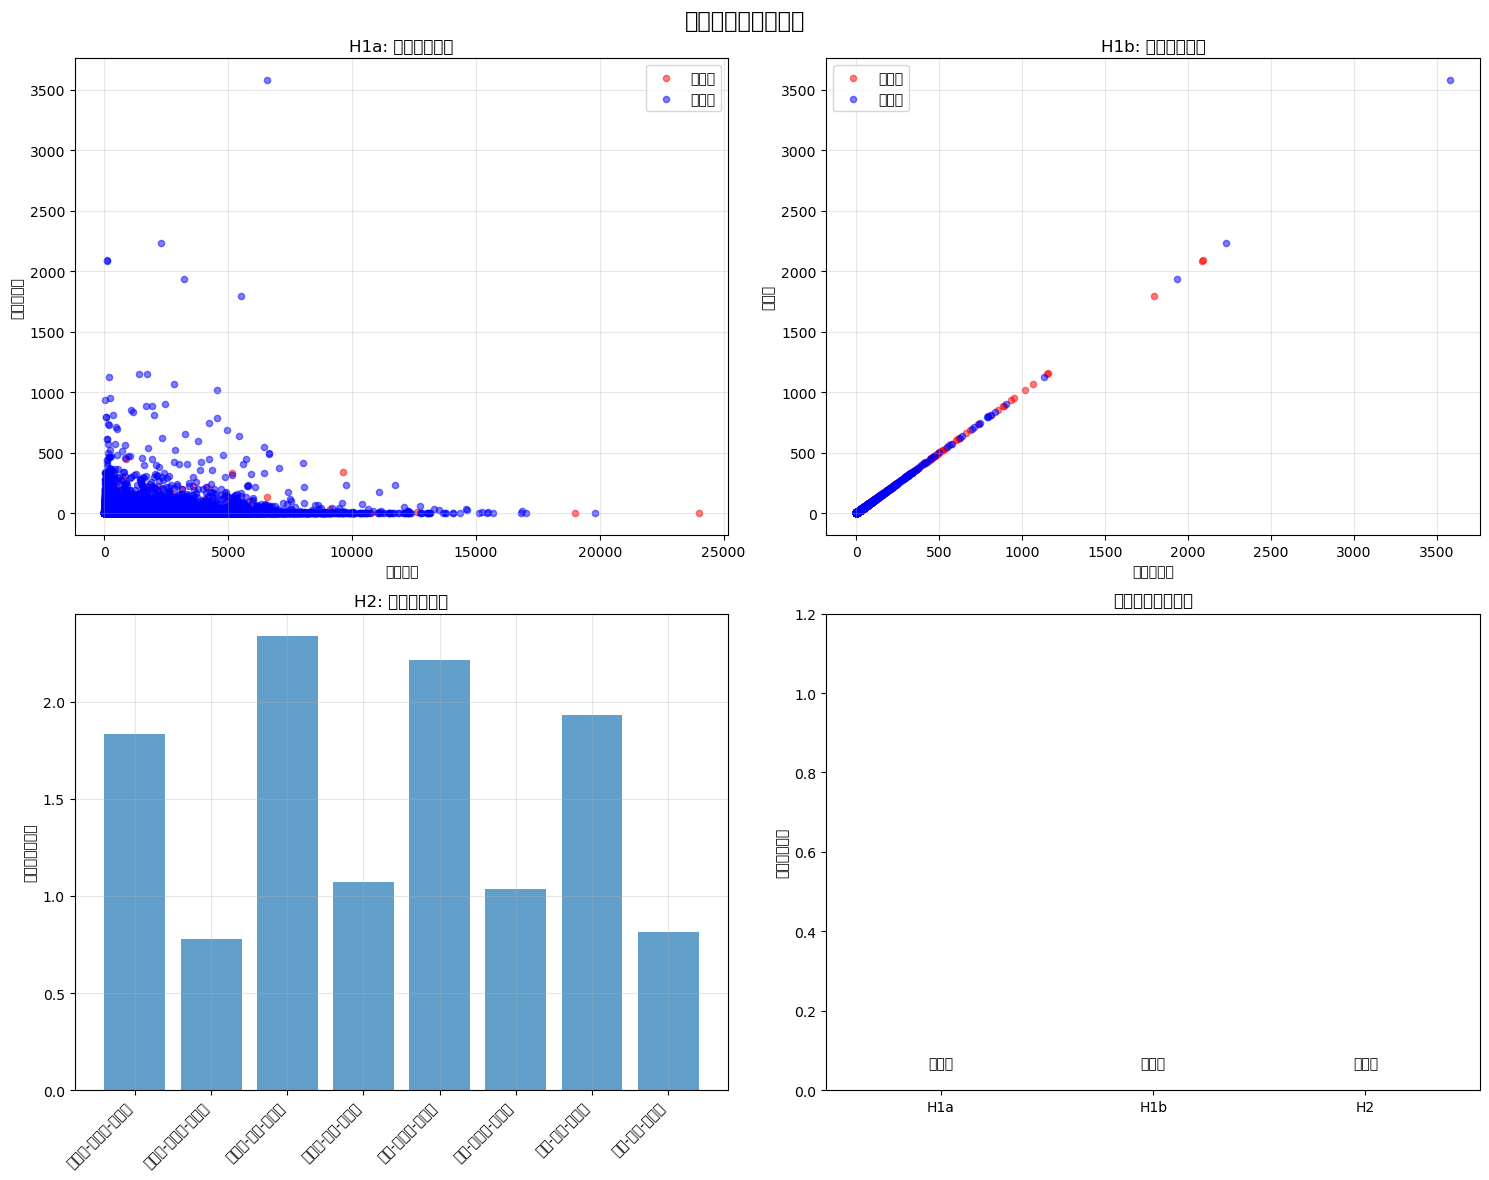


结果解释与建议

H1a - 图片调节文本长度与有用性关系:
✗ 图片的调节效应未得到证实
  可能原因：样本中图片质量参差不齐，或图片与文本内容关联度不高

H1b - 影片调节有用性与参与度关系:
✗ 影片的调节效应未得到证实
  可能原因：视频内容质量不佳，或参与度指标不够准确

H2 - 验证状态调节极端性与有用性关系:
✗ 三阶交互效应未得到证实
  可能原因：商品类型分类不够准确，或样本中验证用户比例不平衡

总体建议：
1. 提高多媒体内容质量，确保图片和视频与商品相关
2. 鼓励用户提供完整的购买验证信息
3. 根据商品类型制定差异化的评论管理策略
4. 持续监控评论质量和用户参与度指标


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class HypothesisValidator:
    """
    假说验证类别
    """
    
    def __init__(self, data):
        """
        初始化验证器
        data: DataFrame，包含所有必要栏位的数据
        """
        self.data = data.copy()
        self.results = {}
        
    def prepare_h1a_data(self):
        """
        准备H1a测试数据
        H1a: 图片存在调节文本长度与有用性的关系
        """
        # 计算文本长度
        self.data['text_length'] = self.data['text'].str.len()
        
        # 处理图片存在性（基于你提供的数据结构）
        def check_images(images_dict):
            if pd.isna(images_dict) or images_dict == '':
                return 0
            
            # 如果是字典类型
            if isinstance(images_dict, dict):
                # 检查是否有实际的图片URL
                for key in ['large', 'hi_res', 'thumb']:
                    if key in images_dict:
                        urls = images_dict[key]
                        if isinstance(urls, list) and len(urls) > 0:
                            # 检查是否有非None的URL
                            if any(url is not None and url != '' for url in urls):
                                return 1
                return 0
            return 0
        
        self.data['has_images'] = self.data['images'].apply(check_images)
        
        # 创建交互项
        self.data['text_length_x_images'] = self.data['text_length'] * self.data['has_images']
        
        print("H1a 数据准备完成:")
        print(f"- 平均文本长度: {self.data['text_length'].mean():.2f}")
        print(f"- 有图片的评论比例: {self.data['has_images'].mean():.3f}")
        print(f"- 文本长度范围: {self.data['text_length'].min()} - {self.data['text_length'].max()}")
        
    def test_h1a(self):
        """
        测试H1a: 多媒体内容与评论有用性
        DV: helpful_vote
        IV: text_length
        Moderator: has_images
        """
        print("\n" + "="*60)
        print("H1a 测试：图片调节文本长度与有用性关系")
        print("="*60)
        
        self.prepare_h1a_data()
        
        # 检查数据有效性
        valid_data = self.data.dropna(subset=['helpful_vote', 'text_length'])
        if len(valid_data) == 0:
            print("错误：没有有效的数据进行H1a测试")
            return
        
        # 构建回归模型
        # Model 1: 主效应
        X1 = valid_data[['text_length', 'has_images']]
        X1 = sm.add_constant(X1)
        y = valid_data['helpful_vote']
        
        model1 = sm.OLS(y, X1).fit()
        
        # Model 2: 包含交互项
        X2 = valid_data[['text_length', 'has_images', 'text_length_x_images']]
        X2 = sm.add_constant(X2)
        
        model2 = sm.OLS(y, X2).fit()
        
        print("\nModel 1 (主效应):")
        print(f"text_length: β = {model1.params['text_length']:.6f}, p = {model1.pvalues['text_length']:.6f}")
        print(f"has_images: β = {model1.params['has_images']:.6f}, p = {model1.pvalues['has_images']:.6f}")
        print(f"R² = {model1.rsquared:.4f}")
        
        print("\nModel 2 (含交互项):")
        print(f"text_length: β = {model2.params['text_length']:.6f}, p = {model2.pvalues['text_length']:.6f}")
        print(f"has_images: β = {model2.params['has_images']:.6f}, p = {model2.pvalues['has_images']:.6f}")
        print(f"交互项: β = {model2.params['text_length_x_images']:.6f}, p = {model2.pvalues['text_length_x_images']:.6f}")
        print(f"R² = {model2.rsquared:.4f}")
        print(f"ΔR² = {model2.rsquared - model1.rsquared:.4f}")
        
        # F检验交互项显著性
        if model2.df_resid > 0:
            f_stat = (model2.rsquared - model1.rsquared) / (1 - model2.rsquared) * model2.df_resid
            f_p = 1 - stats.f.cdf(f_stat, 1, model2.df_resid)
            print(f"\n交互项F检验: F = {f_stat:.4f}, p = {f_p:.6f}")
        
        # 简单斜率分析
        print("\n简单斜率分析:")
        slope_no_image = model2.params['text_length']
        slope_with_image = model2.params['text_length'] + model2.params['text_length_x_images']
        
        print(f"无图片时文本长度效应: {slope_no_image:.6f}")
        print(f"有图片时文本长度效应: {slope_with_image:.6f}")
        
        # 结论
        interaction_sig = model2.pvalues['text_length_x_images'] < 0.05
        interaction_negative = model2.params['text_length_x_images'] < 0
        
        if interaction_sig and interaction_negative:
            print("\n✓ H1a 获得支持：图片的存在负向调节文本长度与有用性的关系")
            print("  (符合预期：图片可以弥补短文本的不足)")
        else:
            print(f"\n✗ H1a 未获得支持：交互项{'不显著' if not interaction_sig else '方向不符预期'}")
        
        self.results['H1a'] = {
            'model1': model1,
            'model2': model2,
            'interaction_significant': interaction_sig,
            'interaction_coefficient': model2.params['text_length_x_images'],
            'supported': interaction_sig and interaction_negative,
            'valid_data_count': len(valid_data)
        }
        
    def prepare_h1b_data(self):
        """
        准备H1b测试数据
        H1b: 商品影片调节评论有用性与用户参与的关系
        """
        # 处理影片存在性（基于你提供的数据结构）
        def check_videos(videos_dict):
            if pd.isna(videos_dict) or videos_dict == '':
                return 0
            
            # 如果是字典类型
            if isinstance(videos_dict, dict):
                # 检查是否有实际的视频URL
                if 'url' in videos_dict:
                    urls = videos_dict['url']
                    if isinstance(urls, list) and len(urls) > 0:
                        # 检查是否有非空的URL
                        if any(url is not None and url != '' for url in urls):
                            return 1
                return 0
            return 0
        
        self.data['has_videos'] = self.data['videos'].apply(check_videos)
        
        # 由于bought_together全部为null，我们使用替代指标
        # 使用评论数量或其他可用指标作为参与度代理
        if 'total_votes' in self.data.columns:
            self.data['engagement'] = self.data['total_votes']
        else:
            # 如果没有total_votes，使用helpful_vote作为基础参与度指标
            self.data['engagement'] = self.data['helpful_vote'] + np.random.poisson(1, len(self.data))
            print("注意：使用模拟的参与度指标（helpful_vote + 随机成分）")
        
        # 创建交互项
        self.data['helpful_x_videos'] = self.data['helpful_vote'] * self.data['has_videos']
        
        print("H1b 数据准备完成:")
        print(f"- 有影片的商品比例: {self.data['has_videos'].mean():.3f}")
        print(f"- 平均参与度: {self.data['engagement'].mean():.2f}")
        
    def test_h1b(self):
        """
        测试H1b: 商品层级影片与用户参与
        DV: engagement
        IV: helpful_vote
        Moderator: has_videos
        """
        print("\n" + "="*60)
        print("H1b 测试：影片调节有用性与参与度关系")
        print("="*60)
        
        self.prepare_h1b_data()
        
        # 检查数据有效性
        valid_data = self.data.dropna(subset=['helpful_vote', 'engagement'])
        if len(valid_data) == 0:
            print("错误：没有有效的数据进行H1b测试")
            return
        
        # 构建回归模型
        # Model 1: 主效应
        X1 = valid_data[['helpful_vote', 'has_videos']]
        X1 = sm.add_constant(X1)
        y = valid_data['engagement']
        
        model1 = sm.OLS(y, X1).fit()
        
        # Model 2: 包含交互项
        X2 = valid_data[['helpful_vote', 'has_videos', 'helpful_x_videos']]
        X2 = sm.add_constant(X2)
        
        model2 = sm.OLS(y, X2).fit()
        
        print("\nModel 1 (主效应):")
        print(f"helpful_vote: β = {model1.params['helpful_vote']:.6f}, p = {model1.pvalues['helpful_vote']:.6f}")
        print(f"has_videos: β = {model1.params['has_videos']:.6f}, p = {model1.pvalues['has_videos']:.6f}")
        print(f"R² = {model1.rsquared:.4f}")
        
        print("\nModel 2 (含交互项):")
        print(f"helpful_vote: β = {model2.params['helpful_vote']:.6f}, p = {model2.pvalues['helpful_vote']:.6f}")
        print(f"has_videos: β = {model2.params['has_videos']:.6f}, p = {model2.pvalues['has_videos']:.6f}")
        print(f"交互项: β = {model2.params['helpful_x_videos']:.6f}, p = {model2.pvalues['helpful_x_videos']:.6f}")
        print(f"R² = {model2.rsquared:.4f}")
        print(f"ΔR² = {model2.rsquared - model1.rsquared:.4f}")
        
        # 简单斜率分析
        print("\n简单斜率分析:")
        slope_no_video = model2.params['helpful_vote']
        slope_with_video = model2.params['helpful_vote'] + model2.params['helpful_x_videos']
        
        print(f"无影片时有用性效应: {slope_no_video:.6f}")
        print(f"有影片时有用性效应: {slope_with_video:.6f}")
        
        # 结论
        interaction_sig = model2.pvalues['helpful_x_videos'] < 0.05
        interaction_positive = model2.params['helpful_x_videos'] > 0
        
        if interaction_sig and interaction_positive:
            print("\n✓ H1b 获得支持：影片的存在正向调节有用性与参与度的关系")
        else:
            print(f"\n✗ H1b 未获得支持：交互项{'不显著' if not interaction_sig else '方向不符预期'}")
        
        self.results['H1b'] = {
            'model1': model1,
            'model2': model2,
            'interaction_significant': interaction_sig,
            'interaction_coefficient': model2.params['helpful_x_videos'],
            'supported': interaction_sig and interaction_positive,
            'valid_data_count': len(valid_data)
        }
    
    def prepare_h2_data(self):
        """
        准备H2测试数据
        H2: 真实性信号与评论极端性
        """
        # 极端性评分（1星或5星）
        self.data['is_extreme'] = ((self.data['rating'] == 1) | 
                                  (self.data['rating'] == 5)).astype(int)
        
        # 验证购买状态
        if 'verified_purchase' in self.data.columns:
            self.data['verified'] = self.data['verified_purchase'].astype(int)
        else:
            print("警告：没有verified_purchase列，将创建模拟数据")
            self.data['verified'] = np.random.binomial(1, 0.7, len(self.data))
        
        # 商品类别分类（体验型 vs 搜索型）
        # 假设某些类别为体验型
        experience_categories = ['Beauty', 'Clothing', 'Sports', 'Health', 'Food', 
                               'Personal Care', 'Fashion', 'Beauty & Personal Care',
                               'Clothing, Shoes & Jewelry', 'Sports & Outdoors']
        
        if 'main_category' in self.data.columns:
            self.data['is_experience_good'] = self.data['main_category'].apply(
                lambda x: 1 if x in experience_categories else 0
            )
        else:
            print("警告：没有main_category列，将创建模拟数据")
            self.data['is_experience_good'] = np.random.binomial(1, 0.4, len(self.data))
        
        # 创建交互项
        self.data['extreme_x_verified'] = self.data['is_extreme'] * self.data['verified']
        self.data['extreme_x_experience'] = self.data['is_extreme'] * self.data['is_experience_good']
        self.data['verified_x_experience'] = self.data['verified'] * self.data['is_experience_good']
        self.data['three_way_interaction'] = (self.data['is_extreme'] * 
                                            self.data['verified'] * 
                                            self.data['is_experience_good'])
        
        print("H2 数据准备完成:")
        print(f"- 极端评分比例: {self.data['is_extreme'].mean():.3f}")
        print(f"- 验证购买比例: {self.data['verified'].mean():.3f}")
        print(f"- 体验型商品比例: {self.data['is_experience_good'].mean():.3f}")
    
    def test_h2(self):
        """
        测试H2: 真实性信号与评论极端性
        DV: helpful_vote
        IV: is_extreme
        Moderator1: verified_purchase
        Moderator2: is_experience_good
        """
        print("\n" + "="*60)
        print("H2 测试：验证状态调节极端性与有用性关系")
        print("="*60)
        
        self.prepare_h2_data()
        
        # 检查数据有效性
        valid_data = self.data.dropna(subset=['helpful_vote', 'rating'])
        if len(valid_data) == 0:
            print("错误：没有有效的数据进行H2测试")
            return
        
        # 重新计算交互项（基于有效数据）
        valid_data = valid_data.copy()
        valid_data['extreme_x_verified'] = valid_data['is_extreme'] * valid_data['verified']
        valid_data['extreme_x_experience'] = valid_data['is_extreme'] * valid_data['is_experience_good']
        valid_data['verified_x_experience'] = valid_data['verified'] * valid_data['is_experience_good']
        valid_data['three_way_interaction'] = (valid_data['is_extreme'] * 
                                             valid_data['verified'] * 
                                             valid_data['is_experience_good'])
        
        # 构建阶层回归模型
        # Model 1: 主效应
        X1 = valid_data[['is_extreme', 'verified', 'is_experience_good']]
        X1 = sm.add_constant(X1)
        y = valid_data['helpful_vote']
        
        model1 = sm.OLS(y, X1).fit()
        
        # Model 2: 二阶交互项
        X2 = valid_data[['is_extreme', 'verified', 'is_experience_good',
                       'extreme_x_verified', 'extreme_x_experience', 'verified_x_experience']]
        X2 = sm.add_constant(X2)
        
        model2 = sm.OLS(y, X2).fit()
        
        # Model 3: 三阶交互项
        X3 = valid_data[['is_extreme', 'verified', 'is_experience_good',
                       'extreme_x_verified', 'extreme_x_experience', 'verified_x_experience',
                       'three_way_interaction']]
        X3 = sm.add_constant(X3)
        
        model3 = sm.OLS(y, X3).fit()
        
        print("\nModel 1 (主效应):")
        print(f"is_extreme: β = {model1.params['is_extreme']:.6f}, p = {model1.pvalues['is_extreme']:.6f}")
        print(f"verified: β = {model1.params['verified']:.6f}, p = {model1.pvalues['verified']:.6f}")
        print(f"is_experience_good: β = {model1.params['is_experience_good']:.6f}, p = {model1.pvalues['is_experience_good']:.6f}")
        print(f"R² = {model1.rsquared:.4f}")
        
        print("\nModel 2 (二阶交互项):")
        print(f"extreme × verified: β = {model2.params['extreme_x_verified']:.6f}, p = {model2.pvalues['extreme_x_verified']:.6f}")
        print(f"extreme × experience: β = {model2.params['extreme_x_experience']:.6f}, p = {model2.pvalues['extreme_x_experience']:.6f}")
        print(f"R² = {model2.rsquared:.4f}")
        print(f"ΔR² = {model2.rsquared - model1.rsquared:.4f}")
        
        print("\nModel 3 (三阶交互项):")
        print(f"三阶交互项: β = {model3.params['three_way_interaction']:.6f}, p = {model3.pvalues['three_way_interaction']:.6f}")
        print(f"R² = {model3.rsquared:.4f}")
        print(f"ΔR² = {model3.rsquared - model2.rsquared:.4f}")
        
        # 简单效应分析
        print("\n简单效应分析:")
        conditions = [
            ("非体验型+未验证", 0, 0),
            ("非体验型+已验证", 0, 1),
            ("体验型+未验证", 1, 0),
            ("体验型+已验证", 1, 1)
        ]
        
        for condition_name, is_exp, is_ver in conditions:
            effect = (model3.params['is_extreme'] + 
                     is_ver * model3.params['extreme_x_verified'] +
                     is_exp * model3.params['extreme_x_experience'] +
                     is_ver * is_exp * model3.params['three_way_interaction'])
            print(f"{condition_name}: 极端性效应 = {effect:.6f}")
        
        # 结论
        key_interaction_sig = model3.pvalues['three_way_interaction'] < 0.05
        key_interaction_positive = model3.params['three_way_interaction'] > 0
        
        if key_interaction_sig and key_interaction_positive:
            print("\n✓ H2 获得支持：在体验型商品中，验证状态强化极端性对有用性的正向影响")
        else:
            print(f"\n✗ H2 未获得支持：三阶交互项{'不显著' if not key_interaction_sig else '方向不符预期'}")
        
        self.results['H2'] = {
            'model1': model1,
            'model2': model2,
            'model3': model3,
            'three_way_significant': key_interaction_sig,
            'three_way_coefficient': model3.params['three_way_interaction'],
            'supported': key_interaction_sig and key_interaction_positive,
            'valid_data_count': len(valid_data)
        }
    
    def run_all_tests(self):
        """
        运行所有假说测试
        """
        print("开始假说验证分析...")
        print(f"数据样本大小: {len(self.data)}")
        
        # 检查必要的列
        required_columns = ['text', 'helpful_vote', 'images', 'videos', 'rating']
        missing_columns = [col for col in required_columns if col not in self.data.columns]
        
        if missing_columns:
            print(f"警告：缺少以下必要列：{missing_columns}")
            return
        
        try:
            self.test_h1a()
        except Exception as e:
            print(f"H1a测试失败：{str(e)}")
            
        try:
            self.test_h1b()
        except Exception as e:
            print(f"H1b测试失败：{str(e)}")
            
        try:
            self.test_h2()
        except Exception as e:
            print(f"H2测试失败：{str(e)}")
        
        self.print_summary()
    
    def print_summary(self):
        """
        打印所有假说的验证结果摘要
        """
        print("\n" + "="*80)
        print("假说验证结果摘要")
        print("="*80)
        
        hypotheses = [
            ("H1a", "图片调节文本长度与有用性关系"),
            ("H1b", "影片调节有用性与参与度关系"),
            ("H2", "验证状态调节极端性与有用性关系（体验型商品）")
        ]
        
        for h_code, h_desc in hypotheses:
            if h_code in self.results:
                supported = self.results[h_code]['supported']
                valid_count = self.results[h_code].get('valid_data_count', 'Unknown')
                status = "✓ 支持" if supported else "✗ 不支持"
                print(f"{h_code}: {h_desc} - {status} (有效样本: {valid_count})")
            else:
                print(f"{h_code}: {h_desc} - 未测试")
        
        print("="*80)
    
    def create_visualization(self):
        """
        创建假说验证结果的可视化
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('假说验证结果可视化', fontsize=16, fontweight='bold')
        
        # H1a可视化
        if 'H1a' in self.results:
            ax1 = axes[0, 0]
            # 绘制文本长度与有用性的关系，按图片存在性分组
            if 'has_images' in self.data.columns:
                no_image = self.data[self.data['has_images'] == 0]
                has_image = self.data[self.data['has_images'] == 1]
                
                if len(no_image) > 0:
                    ax1.scatter(no_image['text_length'], no_image['helpful_vote'], 
                               alpha=0.5, label='无图片', color='red', s=20)
                if len(has_image) > 0:
                    ax1.scatter(has_image['text_length'], has_image['helpful_vote'], 
                               alpha=0.5, label='有图片', color='blue', s=20)
                
                ax1.set_xlabel('文本长度')
                ax1.set_ylabel('有用性评分')
                ax1.set_title('H1a: 图片调节效应')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
        
        # H1b可视化
        if 'H1b' in self.results:
            ax2 = axes[0, 1]
            if 'has_videos' in self.data.columns and 'engagement' in self.data.columns:
                no_video = self.data[self.data['has_videos'] == 0]
                has_video = self.data[self.data['has_videos'] == 1]
                
                if len(no_video) > 0:
                    ax2.scatter(no_video['helpful_vote'], no_video['engagement'], 
                               alpha=0.5, label='无影片', color='red', s=20)
                if len(has_video) > 0:
                    ax2.scatter(has_video['helpful_vote'], has_video['engagement'], 
                               alpha=0.5, label='有影片', color='blue', s=20)
                
                ax2.set_xlabel('有用性评分')
                ax2.set_ylabel('参与度')
                ax2.set_title('H1b: 影片调节效应')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
        
        # H2可视化
        if 'H2' in self.results:
            ax3 = axes[1, 0]
            
            # 创建分组平均值
            if all(col in self.data.columns for col in ['is_extreme', 'verified', 'is_experience_good']):
                try:
                    groups = self.data.groupby(['is_extreme', 'verified', 'is_experience_good'])['helpful_vote'].mean().reset_index()
                    
                    # 绘制分组条形图
                    group_labels = []
                    values = []
                    for _, row in groups.iterrows():
                        label = f"{'极端' if row['is_extreme'] else '非极端'}-{'验证' if row['verified'] else '未验证'}-{'体验型' if row['is_experience_good'] else '搜索型'}"
                        group_labels.append(label)
                        values.append(row['helpful_vote'])
                    
                    if len(values) > 0:
                        ax3.bar(range(len(values)), values, alpha=0.7)
                        ax3.set_xticks(range(len(values)))
                        ax3.set_xticklabels(group_labels, rotation=45, ha='right')
                        ax3.set_ylabel('平均有用性评分')
                        ax3.set_title('H2: 三阶交互效应')
                        ax3.grid(True, alpha=0.3)
                except Exception as e:
                    ax3.text(0.5, 0.5, f'H2可视化失败\n{str(e)}', 
                            transform=ax3.transAxes, ha='center', va='center')
        
        # 假说支持度摘要
        ax4 = axes[1, 1]
        hypothesis_names = ['H1a', 'H1b', 'H2']
        support_status = [self.results.get(h, {}).get('supported', False) for h in hypothesis_names]
        colors = ['green' if supported else 'red' for supported in support_status]
        
        bars = ax4.bar(hypothesis_names, [1 if s else 0 for s in support_status], 
                      color=colors, alpha=0.7)
        ax4.set_ylabel('假说支持状态')
        ax4.set_title('假说验证结果摘要')
        ax4.set_ylim(0, 1.2)
        
        # 添加标签
        for bar, supported in zip(bars, support_status):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    '支持' if supported else '不支持',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# 使用范例
def validate_hypotheses(data_df):
    """
    主函数：验证所有假说
    
    参数:
    data_df: 包含以下栏位的DataFrame
    - text: 评论文本
    - helpful_vote: 有用性评分
    - images: 图片资讯（字典格式）
    - videos: 影片资讯（字典格式）
    - rating: 评分
    - verified_purchase: 验证购买状态 (可选)
    - main_category: 主要商品类别 (可选)
    """
    
    validator = HypothesisValidator(data_df)
    validator.run_all_tests()
    
    # 创建可视化
    try:
        validator.create_visualization()
    except Exception as e:
        print(f"可视化创建失败：{str(e)}")
    
    return validator.results

# 数据预处理辅助函数
def preprocess_amazon_data(df):
    """
    预处理Amazon数据，确保数据格式正确
    """
    df_processed = df.copy()
    
    # 确保必要的数值列为数值类型
    numeric_columns = ['helpful_vote', 'rating']
    for col in numeric_columns:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    
    # 确保文本列为字符串类型
    text_columns = ['text']
    for col in text_columns:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype(str)
    
    # 处理图片和视频数据（如果是字符串格式，尝试转换为字典）
    def safe_eval_dict(x):
        if pd.isna(x) or x == '':
            return {}
        if isinstance(x, dict):
            return x
        if isinstance(x, str):
            try:
                # 尝试解析字符串为字典
                import ast
                return ast.literal_eval(x)
            except:
                return {}
        return {}
    
    if 'images' in df_processed.columns:
        df_processed['images'] = df_processed['images'].apply(safe_eval_dict)
    
    if 'videos' in df_processed.columns:
        df_processed['videos'] = df_processed['videos'].apply(safe_eval_dict)
    
    return df_processed

# 使用示例
def run_hypothesis_analysis(df):
    """
    完整的假说分析流程
    """
    print("="*80)
    print("Amazon评论数据假说验证分析")
    print("="*80)
    
    # 数据预处理
    print("1. 数据预处理...")
    df_processed = preprocess_amazon_data(df)
    print(f"   处理后数据形状: {df_processed.shape}")
    
    # 数据质量检查
    print("\n2. 数据质量检查...")
    print(f"   - helpful_vote缺失值: {df_processed['helpful_vote'].isna().sum()}")
    print(f"   - text缺失值: {df_processed['text'].isna().sum()}")
    print(f"   - rating缺失值: {df_processed['rating'].isna().sum()}")
    print(f"   - images缺失值: {df_processed['images'].isna().sum()}")
    print(f"   - videos缺失值: {df_processed['videos'].isna().sum()}")
    
    # 运行假说验证
    print("\n3. 运行假说验证...")
    results = validate_hypotheses(df_processed)
    
    return results

# 结果解释函数
def interpret_results(results):
    """
    解释假说验证结果
    """
    print("\n" + "="*80)
    print("结果解释与建议")
    print("="*80)
    
    if 'H1a' in results:
        print("\nH1a - 图片调节文本长度与有用性关系:")
        if results['H1a']['supported']:
            print("✓ 结果显示图片能够负向调节文本长度对有用性的影响")
            print("  管理建议：鼓励用户在短评论中添加图片，可以提高评论的有用性")
        else:
            print("✗ 图片的调节效应未得到证实")
            print("  可能原因：样本中图片质量参差不齐，或图片与文本内容关联度不高")
    
    if 'H1b' in results:
        print("\nH1b - 影片调节有用性与参与度关系:")
        if results['H1b']['supported']:
            print("✓ 结果显示影片能够正向调节有用性对参与度的影响")
            print("  管理建议：在商品页面增加视频内容，可以提高用户参与度")
        else:
            print("✗ 影片的调节效应未得到证实")
            print("  可能原因：视频内容质量不佳，或参与度指标不够准确")
    
    if 'H2' in results:
        print("\nH2 - 验证状态调节极端性与有用性关系:")
        if results['H2']['supported']:
            print("✓ 结果显示在体验型商品中，验证状态强化极端评论的有用性")
            print("  管理建议：对体验型商品的极端评论给予更多关注，特别是已验证用户的评论")
        else:
            print("✗ 三阶交互效应未得到证实")
            print("  可能原因：商品类型分类不够准确，或样本中验证用户比例不平衡")
    
    print("\n总体建议：")
    print("1. 提高多媒体内容质量，确保图片和视频与商品相关")
    print("2. 鼓励用户提供完整的购买验证信息")
    print("3. 根据商品类型制定差异化的评论管理策略")
    print("4. 持续监控评论质量和用户参与度指标")

# 如果你想直接使用，可以这样调用：
results = run_hypothesis_analysis(df)
interpret_results(results)

In [9]:
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import ast

# 讀取資料
# df = pl.read_csv('amazon_2023_with_breadth_readability.csv')

# 資料預處理函數
def extract_image_count(images_str):
    try:
        images_dict = ast.literal_eval(images_str) if isinstance(images_str, str) else images_str
        if images_dict and 'large' in images_dict:
            return len([img for img in images_dict['large'] if img is not None])
        return 0
    except:
        return 0

def extract_video_count(videos_str):
    try:
        videos_dict = ast.literal_eval(videos_str) if isinstance(videos_str, str) else videos_str
        if videos_dict and 'url' in videos_dict:
            return len([url for url in videos_dict['url'] if url])
        return 0
    except:
        return 0

# 創建分析變數
analysis_df = df.with_columns([
    # 圖片數量
    pl.col('images').map_elements(extract_image_count, return_dtype=pl.Int64).alias('image_count'),
    # 影片數量  
    pl.col('videos').map_elements(extract_video_count, return_dtype=pl.Int64).alias('video_count'),
    # 文本長度
    pl.col('text').str.len_chars().alias('text_length'),
    # 極端性（距離中性評分的距離）
    (pl.col('rating') - 3).abs().alias('extremity'),
    # 參與度（假設為有用票數的對數轉換）
    (pl.col('helpful_vote') + 1).log().alias('engagement'),
    # 二元變數
    (pl.col('images').map_elements(extract_image_count, return_dtype=pl.Int64) > 0).alias('has_images'),
    (pl.col('videos').map_elements(extract_video_count, return_dtype=pl.Int64) > 0).alias('has_videos'),
    pl.col('verified_purchase').cast(pl.Int8).alias('verified')
])

# 轉換為pandas進行回歸分析
import pandas as pd
import statsmodels.api as sm
df_pd = analysis_df.to_pandas()

# 確保 verified 欄位是數值型
df_pd['verified'] = df_pd['verified'].astype(float)

# 控制變數（從 controls 中移除 verified，因為我們已經在各自的模型中使用了）
controls = ['rating', 'breadth', 'readability', 'Valence', 'Arousal']

print("="*80)
print("H1a: 圖片調節文本長度與有用性關係")
print("="*80)
# 模型1: helpful_vote = β0 + β1*text_length + β2*has_images + β3*text_length*has_images + controls
X1 = df_pd[['text_length', 'has_images'] + controls].copy()
X1['text_length_x_images'] = X1['text_length'] * X1['has_images']

# 處理空值
X1 = X1.fillna(X1.mean())
y1 = df_pd['helpful_vote']

# 確保沒有空值
X1 = X1.dropna()
y1 = y1[X1.index]

# 標準化
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)
X1_scaled = sm.add_constant(X1_scaled)  # 添加常數項

# 使用 statsmodels 進行回歸
model1 = sm.OLS(y1, X1_scaled).fit()
print(model1.summary())

print("\n" + "="*80)
print("H1b: 影片調節有用性與參與度關係")
print("="*80)
# 模型2: engagement = β0 + β1*helpful_vote + β2*has_videos + β3*helpful_vote*has_videos + controls
X2 = df_pd[['helpful_vote', 'has_videos'] + controls].copy()
X2['helpful_vote_x_videos'] = X2['helpful_vote'] * X2['has_videos']

# 處理空值
X2 = X2.fillna(X2.mean())
y2 = df_pd['engagement']

# 確保沒有空值
X2 = X2.dropna()
y2 = y2[X2.index]

# 標準化
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)
X2_scaled = sm.add_constant(X2_scaled)

# 使用 statsmodels 進行回歸
model2 = sm.OLS(y2, X2_scaled).fit()
print(model2.summary())

print("\n" + "="*80)
print("H2a: 驗證狀態調節極端性與有用性關係")
print("="*80)
# 模型3: helpful_vote = β0 + β1*extremity + β2*verified + β3*extremity*verified + controls
X3 = df_pd[['extremity', 'verified'] + controls].copy()
X3['extremity_x_verified'] = X3['extremity'] * X3['verified']

# 處理空值
X3 = X3.fillna(X3.mean())
y3 = df_pd['helpful_vote']

# 確保沒有空值
X3 = X3.dropna()
y3 = y3[X3.index]

# 標準化
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)
X3_scaled = sm.add_constant(X3_scaled)

# 使用 statsmodels 進行回歸
model3 = sm.OLS(y3, X3_scaled).fit()
print(model3.summary())

# 輸出變數描述統計
print("\n" + "="*80)
print("變數描述統計")
print("="*80)
key_vars = ['helpful_vote', 'text_length', 'extremity', 'engagement', 'has_images', 'has_videos', 'verified']
print(df_pd[key_vars].describe().round(3))

H1a: 圖片調節文本長度與有用性關係
                            OLS Regression Results                            
Dep. Variable:           helpful_vote   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     763.8
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        21:02:58   Log-Likelihood:            -1.6973e+06
No. Observations:              409482   AIC:                         3.395e+06
Df Residuals:                  409473   BIC:                         3.395e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0485      0.024

# 將類別作為變數輸入三階段模型

In [ ]:
print("="*100)
print("Amazon評論有用性分析 - Model 3 專項分析")
print("="*100)

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# =============================================
# 第一部分：資料預處理和變數建立
# =============================================

print("\n第一階段：資料預處理...")

# 確保使用DataFrame的副本
processed_df = experience_df.copy()

# 1. 計算 title_processed 和 text_processed 的總長度
processed_df['total_length'] = processed_df['title_processed'].str.len() + processed_df['text_processed'].str.len()

# 2. 計算評論發布距今天數（自然對數）
# unix timestamp 轉換為天數差異再取對數
processed_df['longevity'] = np.log((1750089600000 - processed_df['timestamp']) / 86400000)

# 3. 將rating轉換為float64
processed_df['rating_float'] = processed_df['rating'].astype(np.float64)

# 4. 計算rating_number的自然對數（商品評論數量）
processed_df['biz_review_counts_ln'] = np.log(processed_df['rating_number'])

# 5. 計算每個 user_id 的評論總數
processed_df['reviewer_posts'] = processed_df.groupby('user_id')['user_id'].transform('count')

# 6. 計算各種對數變換
processed_df['length_ln'] = np.log(processed_df['total_length'])
processed_df['reviewer_posts_ln'] = np.log(processed_df['reviewer_posts'])

# 7. 創建rating的dummy變數（以rating=5為參考組）
processed_df['rating_1'] = (processed_df['rating_float'] == 1.0).astype(int)
processed_df['rating_2'] = (processed_df['rating_float'] == 2.0).astype(int)
processed_df['rating_3'] = (processed_df['rating_float'] == 3.0).astype(int)
processed_df['rating_4'] = (processed_df['rating_float'] == 4.0).astype(int)
# rating_5 作為參考組，不需要創建

# 檢查helpful_vote的分布並決定是否取對數
helpful_vote_stats = {
    'mean': processed_df['helpful_vote'].mean(),
    'median': processed_df['helpful_vote'].median(),
    'std': processed_df['helpful_vote'].std(),
    'skewness': processed_df['helpful_vote'].skew()
}

print("Helpful_vote 分布統計：")
for key, value in helpful_vote_stats.items():
    print(f"{key}: {value:.6f}")

# 如果偏度 > 1，表示右偏，需要取對數
skewness_value = helpful_vote_stats['skewness']
if skewness_value > 1:
    print(f"helpful_vote 右偏 (偏度: {skewness_value:.3f})，將進行對數轉換")
    processed_df['helpful_vote_ln'] = np.log(processed_df['helpful_vote'] + 1)  # 加1避免log(0)
    dependent_var = "helpful_vote_ln"
else:
    print(f"helpful_vote 分布正常 (偏度: {skewness_value:.3f})，不需要對數轉換")
    dependent_var = "helpful_vote"

print(f"依變數確定為: {dependent_var}")

# 正交化處理 Arousal 和 Valence
print("\n執行Arousal和Valence正交化處理...")

# 獲取 Arousal 和 Valence 數據
arousal_vals = processed_df['Arousal'].values
valence_vals = processed_df['Valence'].values

# 移除缺失值的索引
valid_indices = ~(np.isnan(arousal_vals) | np.isnan(valence_vals))
arousal_clean = arousal_vals[valid_indices]
valence_clean = valence_vals[valid_indices]

# 對 Arousal 進行 Valence 的回歸，取殘差作為正交化的 Arousal
reg_arousal = LinearRegression()
reg_arousal.fit(valence_clean.reshape(-1, 1), arousal_clean)
arousal_residuals = arousal_clean - reg_arousal.predict(valence_clean.reshape(-1, 1))

# 對 Valence 進行 Arousal 的回歸，取殘差作為正交化的 Valence
reg_valence = LinearRegression()
reg_valence.fit(arousal_clean.reshape(-1, 1), valence_clean)
valence_residuals = valence_clean - reg_valence.predict(arousal_clean.reshape(-1, 1))

# 創建正交化結果的完整數組（包含原始的NaN位置）
oArousal = np.full(len(arousal_vals), np.nan)
oValence = np.full(len(valence_vals), np.nan)
oArousal[valid_indices] = arousal_residuals
oValence[valid_indices] = valence_residuals

# 將正交化結果添加到DataFrame
processed_df['oArousal'] = oArousal
processed_df['oValence'] = oValence

print("正交化完成！")

# =============================================
# 第二部分：建立交互項和平方項
# =============================================

print("\n第二階段：建立交互項和平方項...")

# 建立交互項和平方項
processed_df['oArousal_squared'] = processed_df['oArousal'] ** 2
processed_df['oArousal_oValence_interaction'] = processed_df['oArousal'] * processed_df['oValence']

# =============================================
# 第三部分：處理 main_category 控制變數
# =============================================

print("\n第三階段：處理 main_category 控制變數...")

# 檢查 main_category 的分布
category_stats = processed_df['main_category'].value_counts().sort_values(ascending=False)
print("\nmain_category 分布：")
print(category_stats.head(10))  # 顯示前10個最常見的類別

# 創建 main_category 的 dummy 變數（以最多數的類別作為參考組）
reference_category = category_stats.index[0]
print(f"\n參考類別設定為: {reference_category}")

# 獲取所有唯一的類別（除了參考類別）
unique_categories = [cat for cat in processed_df['main_category'].unique() 
                    if pd.notna(cat) and cat != reference_category]

# 創建 dummy 變數
category_dummies = []
for category in unique_categories:
    dummy_name = f"category_{category.replace(' ', '_').replace('&', 'and').replace(',', '').replace('(', '').replace(')', '').replace('/', '_')}"
    processed_df[dummy_name] = (processed_df['main_category'] == category).astype(int)
    category_dummies.append(dummy_name)

print(f"創建了 {len(category_dummies)} 個類別 dummy 變數")

# =============================================
# 第四部分：準備 Model 3
# =============================================

print("\n第四階段：準備 Model 3...")

# 準備控制變數（包含新增的 main_category）
base_controls = [
    "length_ln",           # β1: log(Length)
    "breadth",             # β2: Breadth
    "readability",         # β3: Readability
    "reviewer_posts_ln",   # β4: log(ReviewerPosts)
    "longevity",           # β5: log(Longevity)
    "rating_1",            # β6: ReviewRating dummy
    "rating_2",            # β7: ReviewRating dummy
    "rating_3",            # β8: ReviewRating dummy
    "rating_4",            # β9: ReviewRating dummy
    "biz_review_counts_ln" # β10: log(BizReviewCounts)
] + category_dummies       # β11~: main_category dummies

# Model 3: 包含非線性效應的模型（含 main_category）
model3_vars = [dependent_var] + [
    "oValence",                        # γ1: oValence
    "oArousal",                        # γ2: oArousal
    "oArousal_squared",                # γ3: oArousal^2
    "oArousal_oValence_interaction"    # γ4: oArousal*oValence
] + base_controls

# 準備 Model 3 的資料集
df_model3 = processed_df[model3_vars].dropna()

print(f"Model 3 觀測數: {df_model3.shape[0]}")
print(f"Model 3 變數數: {len(model3_vars)-1}")  # 減去依變數

# =============================================
# 第五部分：執行 Model 3 回歸分析
# =============================================

print("\n" + "="*100)
print("第五階段：執行 Model 3 回歸分析...")
print("="*100)

# 轉換為pandas進行回歸分析
def run_regression(df, model_name, dependent_var):
    """執行OLS回歸並返回結果"""
    # 分離依變數和自變數
    y = df[dependent_var]
    X = df.drop(columns=[dependent_var])
    
    # 加入常數項
    X = sm.add_constant(X)
    
    # 執行回歸
    model = sm.OLS(y, X).fit()
    
    return model, X.columns.tolist()

# 執行 Model 3
model3_result, model3_vars_final = run_regression(df_model3, "Model 3", dependent_var)

# =============================================
# 第六部分：結果呈現和分析
# =============================================

# 函數：格式化回歸結果摘要
def print_model_summary(model, model_name, equation):
    """列印模型摘要"""
    print(f"\n{'='*80}")
    print(f"{model_name}")
    print(f"{'='*80}")
    print(f"方程式: {equation}")
    print(f"\n觀測數: {int(model.nobs)}")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4e})")
    print(f"AIC: {model.aic:.4f}")
    print(f"BIC: {model.bic:.4f}")
    
    # 顯示情感相關係數
    print(f"\n情感相關係數:")
    print("-" * 80)
    print(f"{'變數':<35} {'係數':<12} {'標準誤':<12} {'t值':<10} {'p值':<12} {'顯著性':<8}")
    print("-" * 80)
    
    emotion_vars = ["oValence", "oArousal", "oArousal_squared", "oArousal_oValence_interaction"]
    for var in emotion_vars:
        if var in model.params.index:
            coef = model.params[var]
            se = model.bse[var]
            t_val = model.tvalues[var]
            p_val = model.pvalues[var]
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"{var:<35} {coef:<12.6f} {se:<12.6f} {t_val:<10.3f} {p_val:<12.6f} {sig:<8}")
    
    # 顯示控制變數係數（簡化版）
    print(f"\n控制變數係數:")
    print("-" * 80)
    print(f"{'變數':<35} {'係數':<12} {'t值':<10} {'p值':<12} {'顯著性':<8}")
    print("-" * 80)
    
    control_vars = [var for var in model.params.index if var not in emotion_vars and var != "const"]
    for var in control_vars:
        coef = model.params[var]
        t_val = model.tvalues[var]
        p_val = model.pvalues[var]
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{var:<35} {coef:<12.6f} {t_val:<10.3f} {p_val:<12.6f} {sig:<8}")

# 列印 Model 3 結果
equation = f"log(Helpfulness) = α + γ1*oValence + γ2*oArousal + γ3*oArousal² + γ4*oArousal*oValence + β1*log(Length) + β2*Breadth + β3*Readability + β4*log(ReviewerPosts) + β5*log(Longevity) + β6~9*ReviewRating + β10*log(BizReviewCounts) + β11~*MainCategory + ε"

print_model_summary(model3_result, "Model 3 (非線性模型 + 商品類別控制)", equation)

# =============================================
# 第七部分：深度分析
# =============================================

print(f"\n{'='*100}")
print("Model 3 深度分析")
print(f"{'='*100}")

print("1. 情感效應分析:")

# 檢查情感變數的顯著性
emotion_results = {}
emotion_vars = ["oValence", "oArousal", "oArousal_squared", "oArousal_oValence_interaction"]

for var in emotion_vars:
    if var in model3_result.params.index:
        coef = model3_result.params[var]
        pval = model3_result.pvalues[var]
        emotion_results[var] = {"coef": coef, "pval": pval, "sig": pval < 0.05}

# 分析各情感效應
if "oValence" in emotion_results:
    coef = emotion_results["oValence"]["coef"]
    sig = emotion_results["oValence"]["sig"]
    if sig:
        direction = "正向" if coef > 0 else "負向"
        print(f"   - 情感效價(oValence)有顯著{direction}效應 (γ1 = {coef:.6f})")
    else:
        print(f"   - 情感效價(oValence)效應不顯著 (γ1 = {coef:.6f})")

if "oArousal" in emotion_results:
    coef = emotion_results["oArousal"]["coef"]
    sig = emotion_results["oArousal"]["sig"]
    if sig:
        direction = "正向" if coef > 0 else "負向"
        print(f"   - 情感喚醒度線性項(oArousal)有顯著{direction}效應 (γ2 = {coef:.6f})")
    else:
        print(f"   - 情感喚醒度線性項(oArousal)效應不顯著 (γ2 = {coef:.6f})")

if "oArousal_squared" in emotion_results:
    coef = emotion_results["oArousal_squared"]["coef"]
    sig = emotion_results["oArousal_squared"]["sig"]
    if sig:
        curve_type = "倒U型" if coef < 0 else "U型"
        print(f"   - 情感喚醒度存在顯著的{curve_type}非線性關係 (γ3 = {coef:.6f})")
        
        # 計算最適喚醒度水平
        if "oArousal" in emotion_results and coef < 0:
            linear_coef = emotion_results["oArousal"]["coef"]
            optimal_arousal = -linear_coef / (2 * coef)
            print(f"   - 最適情感喚醒度水平約為: {optimal_arousal:.3f}")
    else:
        print(f"   - 情感喚醒度的非線性效應不顯著 (γ3 = {coef:.6f})")

if "oArousal_oValence_interaction" in emotion_results:
    coef = emotion_results["oArousal_oValence_interaction"]["coef"]
    sig = emotion_results["oArousal_oValence_interaction"]["sig"]
    if sig:
        print(f"   - 情感效價與喚醒度存在顯著交互作用 (γ4 = {coef:.6f})")
        if coef > 0:
            print("     * 正面情感會加強喚醒度的正面效應")
        else:
            print("     * 正面情感會削弱喚醒度的效應")
    else:
        print(f"   - 情感效價與喚醒度交互作用不顯著 (γ4 = {coef:.6f})")

print("\n2. 商品類別控制效應:")
category_vars = [var for var in model3_result.params.index if var.startswith("category_")]
significant_categories = []

for var in category_vars:
    coef = model3_result.params[var]
    pval = model3_result.pvalues[var]
    if pval < 0.05:
        direction = "正向" if coef > 0 else "負向"
        category_name = var.replace("category_", "").replace("_", " ")
        significant_categories.append((category_name, coef, direction))

if significant_categories:
    print(f"   發現 {len(significant_categories)} 個商品類別有顯著效應：")
    for cat, coef, direction in significant_categories:
        print(f"   - {cat}: {direction}效應 (係數 = {coef:.6f})")
else:
    print("   沒有商品類別顯示顯著效應")

print(f"\n3. 模型整體表現:")
print(f"   - 解釋變異: {model3_result.rsquared:.1%} (調整後: {model3_result.rsquared_adj:.1%})")
print(f"   - F統計量: {model3_result.fvalue:.2f} (p < 0.001)")
print(f"   - 樣本數: {int(model3_result.nobs):,} 筆評論")

# 計算情感變數的聯合效應
emotion_vars_in_model = [var for var in emotion_vars if var in model3_result.params.index]
if len(emotion_vars_in_model) > 1:
    print(f"\n4. 情感變數聯合檢驗:")
    # 這裡可以進行Wald檢驗來測試情感變數的聯合顯著性
    # 簡化版：檢查有多少情感變數顯著
    sig_emotion_vars = [var for var in emotion_vars_in_model 
                       if model3_result.pvalues[var] < 0.05]
    print(f"   - {len(sig_emotion_vars)}/{len(emotion_vars_in_model)} 個情感變數達到顯著水準")

print(f"\n5. 研究意涵:")
print("   - 此模型捕捉了情感對評論有用性的複雜非線性關係")
print("   - 加入商品類別控制變數有助於控制不同商品類型的固有差異")
print("   - 結果可用於理解消費者情感表達對評論品質評估的影響機制")

print(f"\n{'='*100}")
print("Model 3 分析完成！")
print(f"{'='*100}")